<a href="https://colab.research.google.com/github/KarlaVega1201/Coursera_Capstone/blob/main/week08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 8 - Support Vector Machines
by Colin Rundel & David Elliott & Ozan Evkaya

1. [Setup](#setup)

2. [Separable and Non separable Data Cases](#RBH)

3. [Model refinement](#refine)

4. [Default Data for Binary Example](#mclog)

5. [Tickets Data for Multi-class Example](#SKV)




In this section we will be exploring the basics of support vector machine models. SVMs have their own entire submodule of sklearn which includes more than we will be able to cover in this workshop. We will be focusing on the most straight forward case, which is a support vector machine classifier which is provide by sklearn as the SVC model. For the details please have a look at

https://scikit-learn.org/stable/modules/svm.html

NOTE THAT, for the simplicity we did not use any data partitioning in below for toy data examples. But for the real data sets, we have the data splitting procedure as a general one. For the multi-class example, the test data is already available so you do not need further partitioning in it. 

---

# 1. Setup <a id='setup'></a>

## 1.1. Uploading your data to the colab
This notebook will be saved in your google drive in a folder "Colab Notebooks" by default, you should be fairly familiar with this by now.

When you run this cell you will need to give colab permission to access files in your drive.

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/week-8')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
week08.ipynb  week-08.zip  ws-material


We will now unzip the workshop materials and place them in a subdirectory "ws-material/"

In [3]:
if not os.path.exists('ws-material'):
  print('Unzipping materials...')
  !unzip week-08.zip -d ws-material
else:
  print("Directory already exists!")

os.chdir('ws-material')
!ls

Directory already exists!
week-08


__Reminder__ 

- You may need to restart the runtime several times in the workshop, but you will not need to re-upload or unzip files again. 

## 1.2 Packages

Now lets load in the packages you wil need for this workshop.

In [4]:
# Display plots inline
%matplotlib inline  

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.markersize'] = 7.5

# sklearn modules
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
import warnings # prevent warnings
import joblib # saving models
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform
import itertools
from sklearn.model_selection import GridSearchCV, KFold
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For loading SVC from sklearn
from sklearn.svm import SVC



##  1.3 Helper Functions

Below are two helper functions we will be using in this workshop.

In [5]:
# About visualization of margins in figures
def plot_margin(model, data, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50):
    # Plot the data
    p = sns.scatterplot(x=x, y=y, hue=cat, data=data, legend=False)
    
    # Find the extent of x and y
    xlim = p.get_xlim()
    ylim = p.get_ylim()
    
    # Create a grid of points
    xx = np.linspace(xlim[0], xlim[1], nx)
    yy = np.linspace(ylim[0], ylim[1], ny)
    YY, XX = np.meshgrid(yy, xx)
    
    # Calculate the label for each point in the grid
    xy = np.c_[XX.ravel(), YY.ravel()]
    Z = model.decision_function(xy).reshape(XX.shape)
    
    # plot contours of decision boundary and margins
    p.contour(XX, YY, Z, colors='k', 
              levels=[-1, 0, 1], alpha=0.5,
              linestyles=['--', '-', '--'])

    # highlight support vectors
    if (show_support_vectors):
        p.scatter(model.support_vectors_[:, 0], 
                  model.support_vectors_[:, 1], s=100,
                  linewidth=1, facecolors='none', edgecolors='k')

    # Show confusion table in the title
    p.set_title(
        "TN: {0}, FP: {1}, FN: {2}, TP: {3}".format(
            *confusion_matrix(
                data[cat],
                model.predict(data.drop(cat, axis=1))
            ).flatten()
        )
    )
    
    plt.show()

# For data set example, plot boundries
def plot_boundaries(bounds, x='lon', y='lat', group='precinct', n=5):
    """ Draws boundary lines for a series of groups polygons in a dataframe
    """
    sns.lineplot(x=x, y=y, hue=group, data=bounds,
                 sort=False, palette=['k']*n, legend=None)
    
# For the predicted and true labels in the plot
def plot_pred_labels(res, pred = 'pred_label', truth = 'precinct'):
    """ Plots the predicted labels and true labels from a common data frame
    """
    plt.figure(figsize=(5,8))
    
    ax = sns.scatterplot(
        x='lon', y='lat', hue=pred, palette=precinct_pal, data=res
    )
    plot_boundaries(manh_bounds)
    
    acc = sklearn.metrics.accuracy_score(
        res[truth], res[pred]
    )
    
    ax.set_title("Predicted Labels (Accuracy {:.3f})".format(acc))
    
    plt.show()

#Model test assessment function to use it below 
def model_test_assess(model, inc_report = True, inc_proba = False):
    # Use the model to predict test labels
    res = pd.concat(
        [ manh_test,
          pd.Series(
              data = model.predict(manh_test[['lon','lat']]),
              name = "pred_label"
          )
        ], 
        axis = 1
    )
        
    if (inc_proba):
        res = pd.concat(
            [ res, 
              pd.DataFrame(
                  data = model.predict_proba(manh_test[['lon','lat']]),
                  columns = precincts_pred
              )
            ], 
            axis = 1
        )
    
    # Plot labels
    plot_pred_labels(res)
    
    if inc_report: # Print report
        print(
            sklearn.metrics.classification_report(
                res.precinct, res.pred_label,
                zero_division = 0
            )
        )

# for fitting and assess this model using different kernel and penalty values.
def fit_svc(kernel, C):
    m_svc = make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.SVC(C=C, kernel=kernel)
    ).fit(X,y)
    
    model_test_assess(m_svc)

## 1.4 Separable Data

We will begin by examining several toy data problems to explore the basics of these models. To begin we will read in data for the first example from ex1.csv





In [20]:
ex1 = pd.read_csv("./week-08/Data/ex1.csv")
ex1.head(10)

,x,y,z
0,-0.56,-1.07,A
1,-0.23,-0.22,A
2,1.56,-1.03,A
3,0.07,-0.73,A
4,0.13,-0.63,A
5,1.72,-1.69,A
6,-1.27,0.15,A
7,-0.69,-1.14,A
8,2.22,1.43,B
9,1.36,0.70,B


We can see the that data is composed of two classes in two dimensions, and it is clear that these two classes are perfectly linearly separable

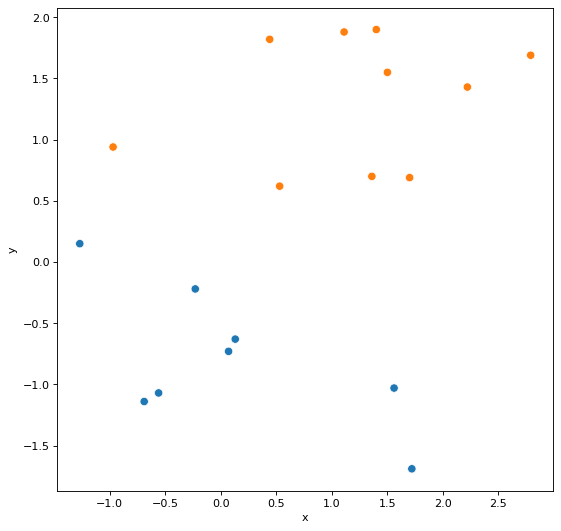

In [6]:
sns.scatterplot(x='x', y='y', hue='z', data=ex1, legend=False)
plt.show()

---

### 🚩 Exercise 1

Like the other models we've already seen, we fit the SVM by constructing our feature matrix and outcome vector and then calling the fit method for our model object;

1. Separate the features and outcome in the toy dataset ex1.csv
2. Fit a SVC model for this data set using SVC() function (Note that you need to change the default value of kernel and parameter C)
3. Visualize the decision boundary and the margins using the plot_margin function we defined above.
4. How many support vectors are there for this model?
5. How does the boundary line and the margins change as you change the value of C?


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


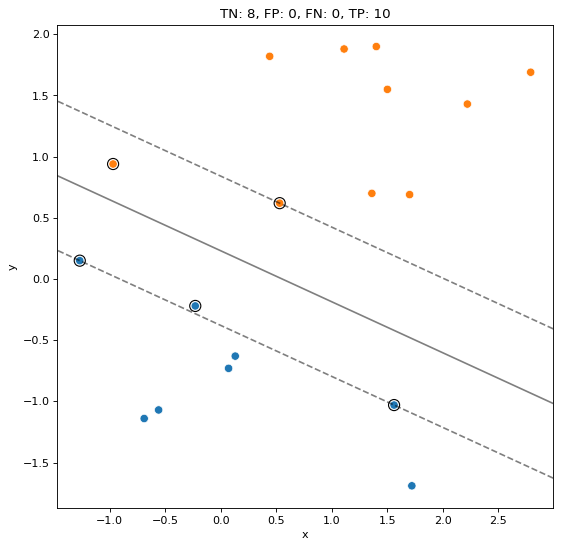

In [102]:
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn import svm, datasets

# Separate the features and outcome in the toy dataset ex1.csv
X = ex1.drop('z', axis=1) # Independet variable
y = ex1['z']              # dependent variable

#Fit a SVC model for this data set using SVC() function
model = svm.SVC(kernel='linear')
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex1, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)
    

---

**!!! Add your text solution here !!!**

There are two classes of observations, shown in blue and in orange.
The hyperplane is shown as a solid line and the margins are shown as dashed lines. (The margin is the distance from the solid line to either of the dashed lines). All of the observations are on the correct side of the margin. 
The two blue points and the one orange point that lie
on the dashed lines are the support vectors, the other observations inside the dashed line are just training data.

When C is small, we seek narrow margins that are rarely violated; this amounts to a classifier that is highly fit to the data, which may have low bias but high variance.
When C is larger, the margin is wider and we allow more violations to it; this
amounts to fitting the data less hard and obtaining a classifier that is potentially more biased but may have lower variance.

## 1.5 Non-Separable Data

We will not complicate our previous example somewhat by adding two additional points from the blue A class to our data. This is available in the ex2.csv file.

      x     y  z
0 -0.56 -1.07  A
1 -0.23 -0.22  A
2  1.56 -1.03  A
3  0.07 -0.73  A
4  0.13 -0.63  A


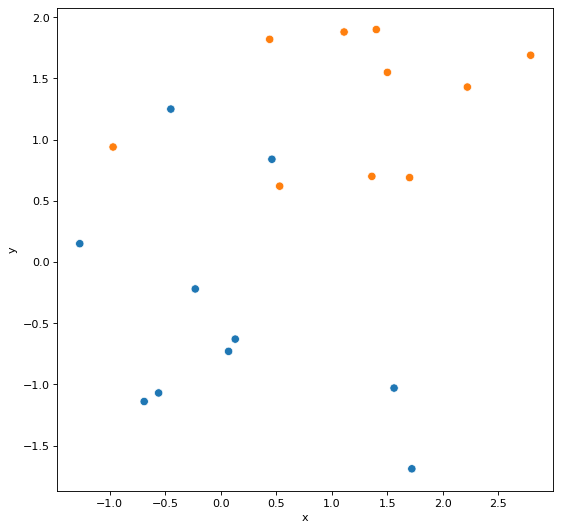

In [25]:
ex2 = pd.read_csv("./week-08/Data/ex2.csv")
print(ex2.head())

# To visualize
sns.scatterplot(x='x', y='y', hue='z', data=ex2, legend=False)
plt.show()


---

### 🚩 Exercise 2

1. Are these two classes linearly separable?
2. Fit a SVC model to these data using the same code we used with example 1.
3. How does the "fit" of this model differ compared to the "fit" for example 1. Hint - make your comparison for equivalent values of C.
4. How do the boundary line and margins change as you change the value of C?




/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


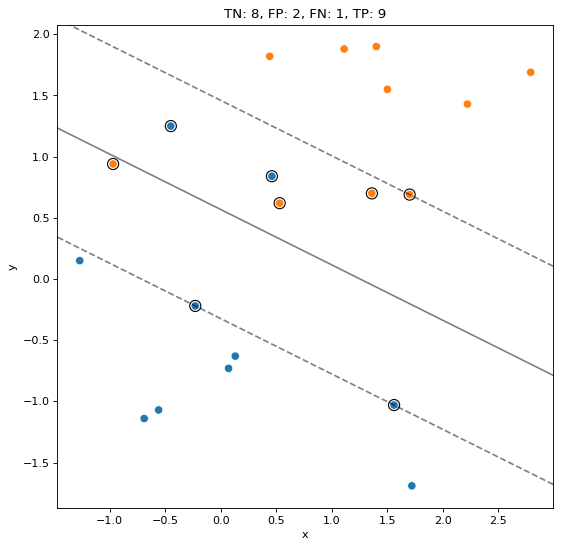

In [103]:
X = ex2.drop('z', axis=1) # Independet variable
y = ex2['z']              # dependent variable

#Fit a SVC model for this data set using SVC() function
model = svm.SVC(kernel='linear')
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex2, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)

---

**!!! Add your comments about the answer here !!!**

No, this model is not lineal separated. In this case, the two classes are not separable by a hyperplane, and so the maximal margin classifier
cannot be used.

The hyperplane is shown as a solid line and the margins are shown as dashed lines. (The margin is the distance from the solid line to either of the dashed lines). Some of the observations are on the incorrect side of the margin. 
The two blue points and the one orange point that lie on the dashed lines are the support vectors, the other observations inside the dashed line are just training data.

The same logic applies for C
When C is small, we seek narrow margins that are rarely violated; this amounts to a classifier that is highly fit to the data, which may have low bias but high variance.
When C is larger, the margin is wider and we allow more violations to it; this
amounts to fitting the data less hard and obtaining a classifier that is potentially more biased but may have lower variance.

Note that there are one orange and two blue observations on the wrong side of the hyperplane and the wrong side of the margin


`

## 2 Non-linear Case

Next we will look at a new data set that would seem to also fall in the non-separable category. The data set that we are using is ex3.csv now



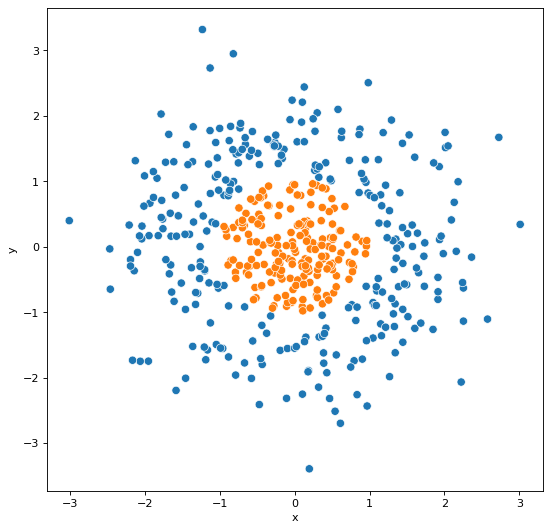

In [27]:
# For the new data set 
ex3 = pd.read_csv("./week-08/Data/ex3.csv")

# To visualize
sns.scatterplot(x='x', y='y', hue='z', data=ex3, legend=False)
plt.show()

---

### 🚩 Exercise 3

For this data we will consider a simple polynomial kernel with degree 2 
(choose first C = 1 ) and visualize the margins using `plot_margin()` again

More details on the various kernels that can be used with the SVC model are available 
https://scikit-learn.org/stable/modules/svm.html#svm-kernels

The kernel function can be any of the following:

- linear : $\langle x, x'\rangle$
- polynomial : $(\gamma \langle x, x'\rangle + r)^d$
- rbf : $\exp(-\gamma \|x-x'\|^2)$ where  $\gamma$ is specified by parameter gamma, must be greater than 0
- sigmoid : $\tanh(\gamma \langle x,x'\rangle + r)$ where $r$ is specified by `coef0`

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


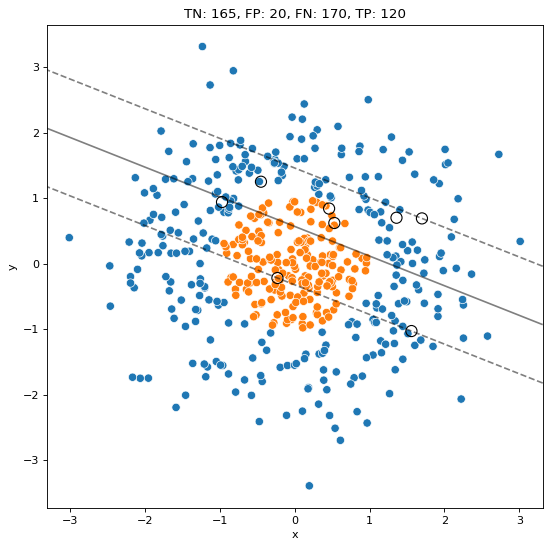

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


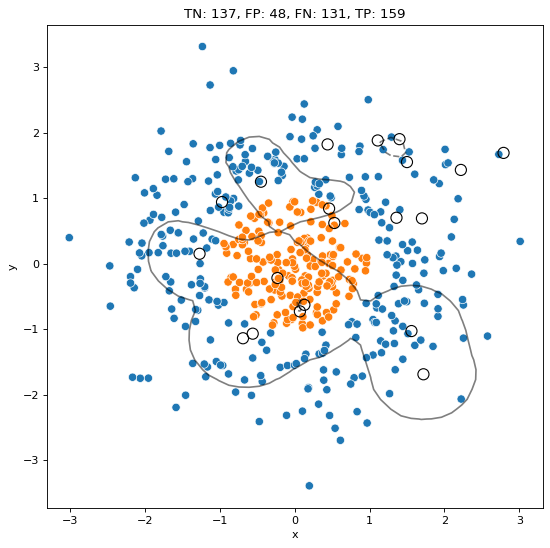

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


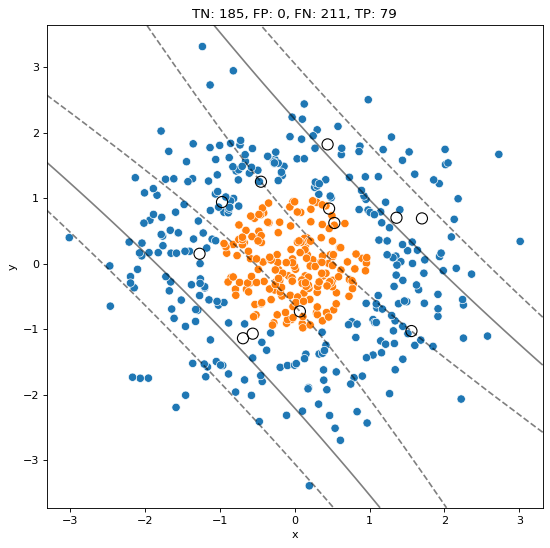

In [104]:
model = svm.SVC(kernel='linear', C=1.0, degree=2)
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)


model = svm.SVC(kernel='rbf', C=0.55,gamma=6)
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)


model = svm.SVC(kernel='poly', C=1.0, degree=2)
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)

---

### 🚩 Exercise 4

Based on the above fitted models

1. Compare the fit of the model using the polynomial and linear kernel. Describe the shape of the boundaries and the margins.

2. How do the boundary line and margins change as you change the value of C?

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


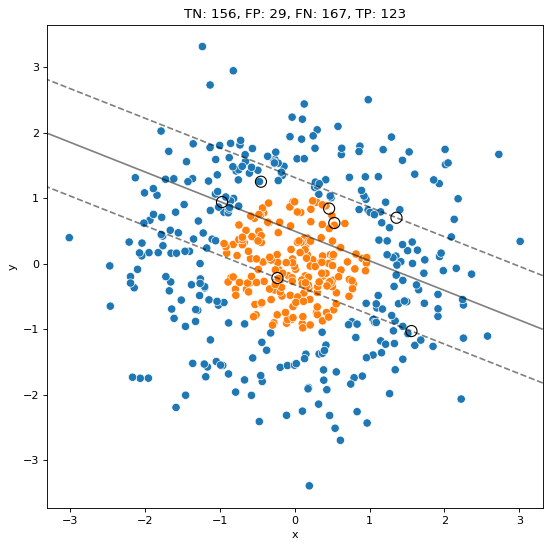

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


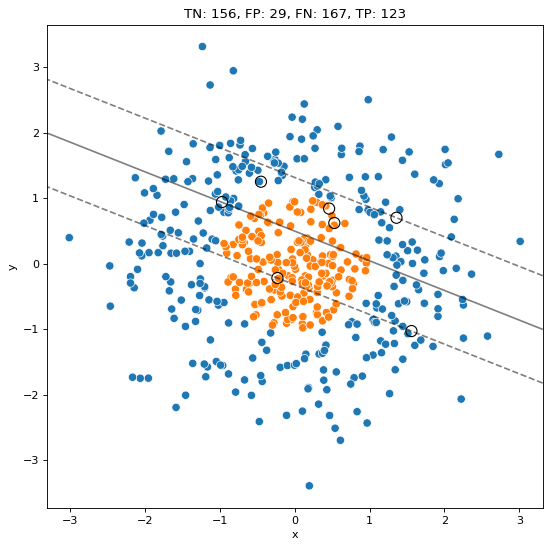

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


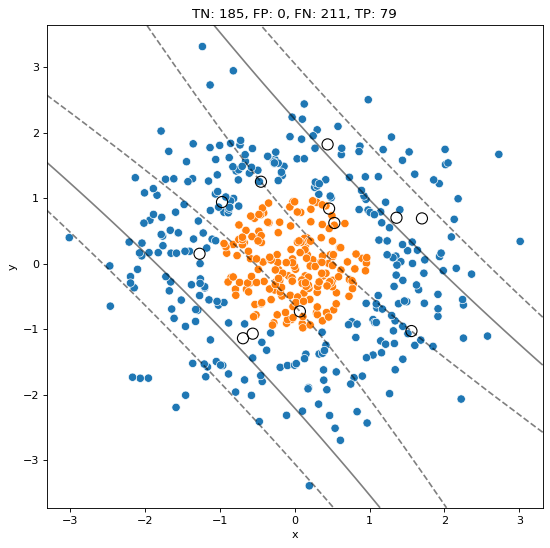

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


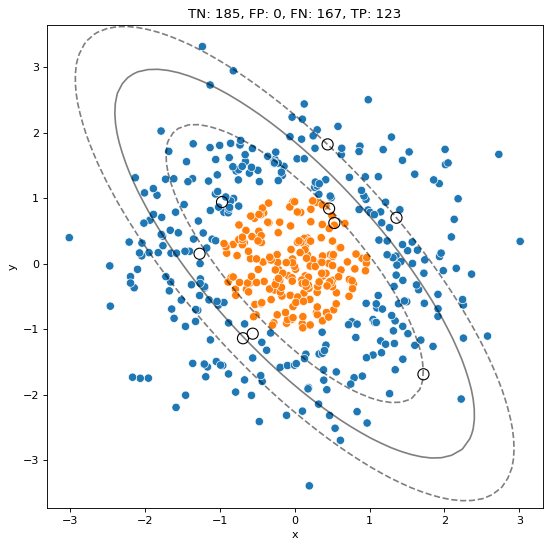

In [105]:
model = svm.SVC(kernel='linear', C=2.0, degree=2)
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)

model = svm.SVC(kernel='linear', C=5.0, degree=2)
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)

##########################
     ## polynomial ##

model = svm.SVC(kernel='poly', C=1, degree=2)
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)

model = svm.SVC(kernel='poly', C=100, degree=2)
clf = model.fit(X, y)

# Visualize the decision boundary and the margins using the plot_margin function we defined above
plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)

The data is not lineal, so the kernel= "lineal" is not the best approach to fit the model. 

Then we fit the model with a poly degree 2 which seems to be a better approach for the data. We plot two different C, one with C= 1 and the other with C= 100 (we use these extremes values just to know and visualize the difference). We observe that a C= 100 fits better the data, however the output will be more biased but may have lower variance

## 2.1 Other Kernels

Next we will consider an even more complicated separation task where one class is split into two separate clusters by the second class. The data ara available as ex4.csv.

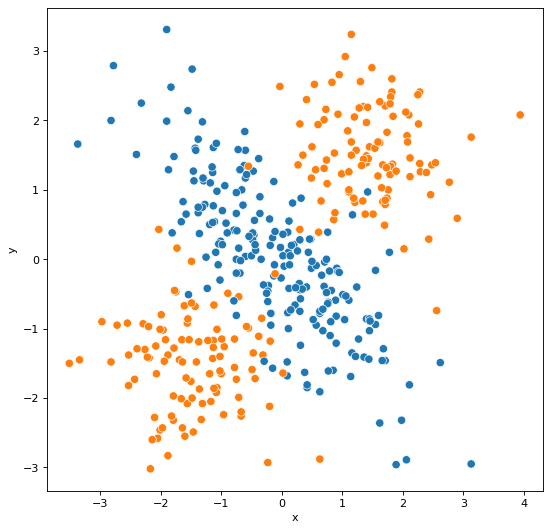

In [73]:
# For the new data set 
ex4 = pd.read_csv("./week-08/Data/ex4.csv")

# To visualize
plt.figure(figsize=(8, 8))
sns.scatterplot(x='x', y='y', hue='z', data=ex4, legend=False)
plt.show()

---

### 🚩 Exercise 5

Set up a function for experimenting with different penalties and kernel functions for this dataset (ex4.csv). For this purpose, consider, 

1. **C** in $[1,5,10,50,100]$
2. **degree** in $[2,3,4]$
3. **kernel** in $['poly', 'rbf', 'linear'])$

inside of the `SVC()` function. Note that the degree value is only used by polynomial kernel and is ignored by the linear and rbf kernels. 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


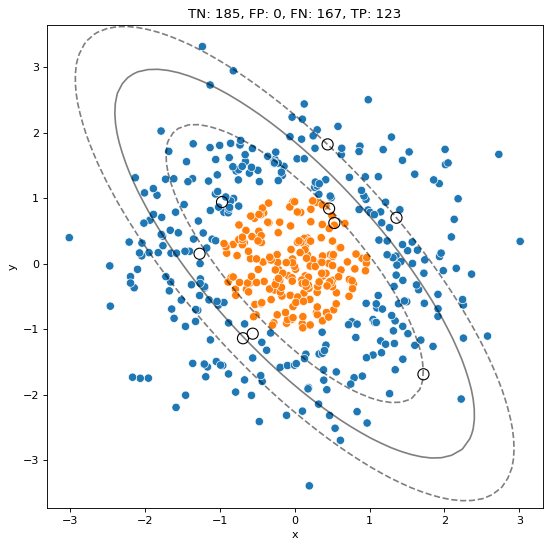

In [106]:
# Kernel = ′poly′,′rbf′,′linear′]
# C in  [1,5,10,50,100] 
# degree in  [2,3,4]

def test_SVC(kernel, C, degree):

  if kernel == "poly":
    model = svm.SVC(kernel = kernel, C=C, degree = degree)
    clf = model.fit(X, y)

  if kernel == "rbf":
    model = svm.SVC(kernel = kernel, C=C)
    clf = model.fit(X, y)

  if kernel == "linear":
    model = svm.SVC(kernel = kernel, C=C)
    clf = model.fit(X, y)

  return plot_margin(model, ex3, x='x', y='y', cat='z', show_support_vectors = True, nx=50, ny=50)

test_SVC("poly", C= 100, degree = 2)

---

### 🚩 Exercise 6

Based on the above fitted models

1. What combination of parameters appears to produce the best fit? Is it easy to tell this by visual inspection alone?

2. How do the support vectors change as the kernel, penalty, and degree are changed?



The best approach seems to be a polynomial feature of degree = 2 and C >= 10. 
It is easy to visualize with the plots, however we should note that this is not enough as we have to be careful of not overfitting or underfitting the data.

The support vector are almost the same when C >= 10, however if C = 1 then the number of support vectors increase. 

## 3 Model Assessment

So far we have only inspected the various models by eye to get a sense of how well they fit our data. Since we are undertaking a classification task here we would like to be able to leverage the metrics and scoring tools we have already learned around logistic regression and related tools. The issue is that while we could generate a simple confusion matrix for our models' predictions this is somewhat limiting.

By default, SVM models do not support the construction of anything like a ROC curve since the predictions are not probabilistic - i.e. labels are assigned based on which side of the separator a point falls. As such, SVC models do not implement predict_proba by default

---

### 🚩 Exercise 7

Based on the best model that you visualized above, in Exercise 6

1. Report the accuracy of the model
2. Obtain the confusion matrix and interpret the results in terms of the quantities defined below 

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP}+ \text{FN}}
$$

$$
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$

$$
F1 = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right)
$$



The accuracy is 85.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


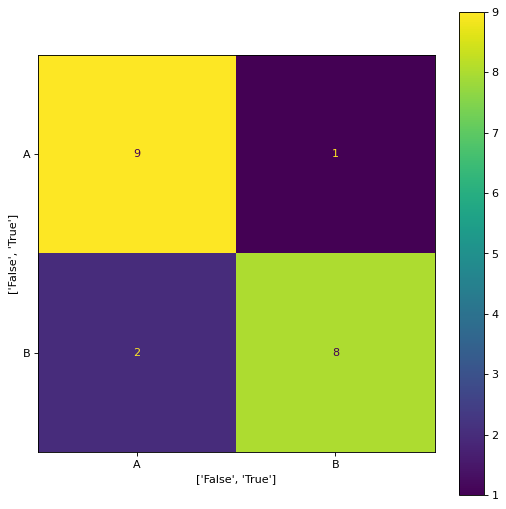

The recall value was: 0.4241379310344828, precision: 1.0 and F1:0.5956416464891041


In [122]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

pred = clf.predict(X)
accuracy = accuracy_score(y, pred)*100
print(f'The accuracy is {accuracy}')

def conf_matrix(FP,TP,FN,TN):
  recall = TP/(TP + FN)
  precision = TP / (TP + FP)
  F1 = 2*((recall*precision)/(recall + precision))
  print(f'The recall value was: {recall}, precision: {precision} and F1:{F1}')

plot_confusion_matrix(clf, X, y)  
plt.show()

conf_matrix(0,123,167,185)

**!!! Add your comments about the model performance here !!!**

Accuracy should be high as possible, in this case our accuracy is 85.

FN > TP in that output, as a result Recall value is small for that logistic fit trial. Because of the that F1 score is also around 0.5. We can improve our model by increasing TP and decrease FN. The value of FP = 0 does that the precision is equal to 1 

---

### 🚩 Exercise 8

With the available scoing metrics we can make use of the usual cross valiation tools such as cross_val_score which can be useful for the purpose of comparing different models,

1. Run the following code and get the result
2. Rearrange the ingridients of th code given below for 2-degree poylnomial kernel, compare the result with the output of 1. 
3. If you adjust $C$ are you able to find a better performing version of either the rbf or poly SVM models?



In [135]:
X_ex4 = X
y_ex4 = y

rbf = sklearn.model_selection.cross_val_score(
    SVC(kernel='rbf', C=1, gamma='scale'), 
    X_ex4, y_ex4, 
    cv=KFold(5, shuffle=True, random_state=1234)
)

print("with C= 1, %0.2f accuracy with a standard deviation of %0.2f" % (rbf.mean(), rbf.std()))

rbf_1 = sklearn.model_selection.cross_val_score(
    SVC(kernel='rbf', C=100, gamma='scale'), 
    X_ex4, y_ex4, 
    cv=KFold(5, shuffle=True, random_state=1234)
)

print("with C= 100, %0.2f accuracy with a standard deviation of %0.2f" % (rbf_1.mean(), rbf_1.std()))

with C= 1, 0.80 accuracy with a standard deviation of 0.19
with C= 100, 0.75 accuracy with a standard deviation of 0.00


In [136]:
poly_1 = sklearn.model_selection.cross_val_score(
    SVC(kernel='poly', C=10000, degree=2), 
    X_ex4, y_ex4, 
    cv=KFold(5, shuffle=True, random_state=1234)
)

print("with C= 100, %0.2f accuracy with a standard deviation of %0.2f" % (poly_1.mean(), poly_1.std()))

poly = sklearn.model_selection.cross_val_score(
    SVC(kernel='poly', C=1, degree=2), 
    X_ex4, y_ex4, 
    cv=KFold(5, shuffle=True, random_state=1234)
)

print("with C= 1, %0.2f accuracy with a standard deviation of %0.2f" % (poly.mean(), poly.std()))

with C= 100, 0.75 accuracy with a standard deviation of 0.27
with C= 1, 0.75 accuracy with a standard deviation of 0.27


---

**!!! Add your comments here !!!**

As seen with the model rbf, if the C value is small (c=1) then the accuracy is higher however we obtained a higher std deviation as well. 

For poly fit the values are similar even when the values of C change from c=1 to C= 100. 

---

### 🚩 Exercise 9

Construct a full cross validated grid search over the parameter values: $C = np.linspace(0.1, 10, 100)$, degree = $[2,3,4]$, and kernel = $['poly', 'rbf', 'linear']$.

Which SVM model performs best? Use plot_margin to show the resulting seperator and support vectors.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


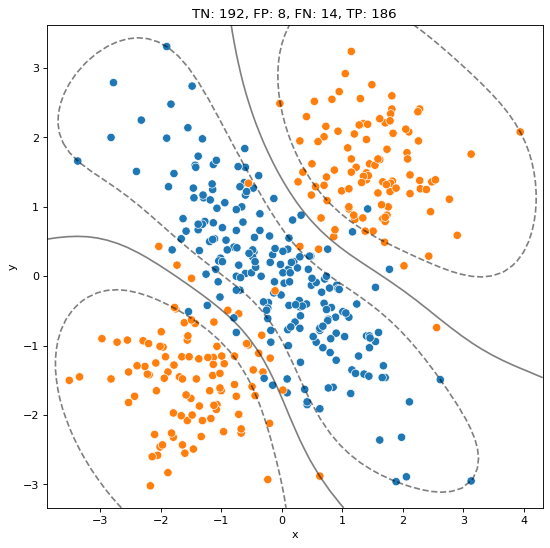

In [153]:
# Separate the features and outcome in the toy dataset ex1.csv
X = ex4.drop('z', axis=1) # Independet variable
y = ex4['z']              # dependent variable

cv = GridSearchCV(
    SVC(),
    param_grid = { 
        'kernel':['poly','rbf','linear'], 
        'C': np.linspace(0.1,10,100),
        'degree': [2,3,4]
    },
    cv = KFold(5, shuffle=True, random_state=1234)
)

# Fit the model on ex4 data set
#Fit a SVC model for this data set using SVC() function
#model = svm.SVC(kernel='linear')
#clf = model.fit(X, y)

cv.fit(X, y)
sorted(cv.cv_results_.keys())
# Get the best model parameters and the accuracy of the model
plot_margin(cv, ex4, x='x', y='y', cat='z', show_support_vectors = False, nx=50, ny=50)

The accuracy is 91.75


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


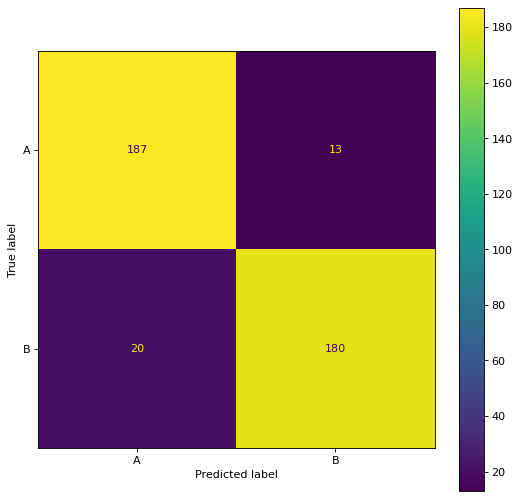

The recall value was: 0.93, precision: 0.9587628865979382 and F1:0.9441624365482233


In [154]:
pred = clf.predict(X)
accuracy = accuracy_score(y, pred)*100
print(f'The accuracy is {accuracy}')

def conf_matrix(FP,TP,FN,TN):
  recall = TP/(TP + FN)
  precision = TP / (TP + FP)
  F1 = 2*((recall*precision)/(recall + precision))
  print(f'The recall value was: {recall}, precision: {precision} and F1:{F1}')

plot_confusion_matrix(clf, X, y)  
plt.show()

conf_matrix(8,186,14,192)

## 4 Default Data for Binary Case

The dataset consists of 10000 individuals and whether their credit card has defaulted or not. Below is the column description: The main aim is to build the model using Logistic Regression and predict the accuracy of it. The included columns in the data set are as follows:

* `default` - Whether the individual has defaulted

* `student` - Whether the individual is the student

* `balance` - The balance in the individual's account

* `income` - Income of an individual

We read the data into python using pandas.





In [148]:
df_default = pd.read_csv("./week-08/Data/Default.csv", index_col=0)

# for now lets just drop the student varible.
df_default = df_default.drop("student", axis=1)
df_default.head()

,default,balance,income
1,No,729.526495,44361.62507
2,No,817.180407,12106.13470
3,No,1073.549164,31767.13895
4,No,529.250605,35704.49394
5,No,785.655883,38463.49588


---

### 🚩 Exercise 10

1. Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**) Use the test size as $10\%$ of the whole sample

2. Convert your response variable into the numerical format

3. Use the following function to get a RandomizedSearch results and sort your model results in terms of the value of "mean_test_recall". Comment on the obtained result in terms of accuracy and recall

NOTE: You can check the details in the Week07 workshop solutions



In [155]:
from sklearn.model_selection import train_test_split

# Feature matrix and response separation 
data_x, data_y = df_default.drop(['default'], axis=1), df_default['default']

print(data_x.shape)
print(data_y.shape)

features = list(data_x.columns)
X_train, X_test, y_train, y_test = train_test_split(data_x.values, data_y.values, stratify = data_y, 
                                                    test_size = 0.1, random_state=42)


#Converting the response variable 
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)


(10000, 2)
(10000,)


In [156]:
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2

linear_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(random_state=42))
    ])
# specify parameters and distributions to sample from
lin_param_dist = {'svm_clf__C':loguniform(C_list[0], C_list[-1])}

lin_rs = RandomizedSearchCV(linear_svm, lin_param_dist, n_iter=60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv=StratifiedKFold(n_splits=5),
                            refit="recall", 
                            random_state=42,
                            return_train_score=True)

lin_rs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_clf',
                                              LinearSVC(random_state=42))]),
                   n_iter=60,
                   param_distributions={'svm_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6c1c974350>},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

## 5 Geocoded Tickets Data for Multi-class Case

The new data comes from New York City's Open Data project. We have simplified the data somewhat and restricted the data to just include the five precincts (1st, 5th, 6th, 7th, and 9th) in the southern end of Manhattan. The following data files have been provided:

- manh_tickets.csv - Geocoded parking tickets from the 5 southern most precincts in Manhattan

- manh_test.csv - Points randomly sampled within the true boundaries of these precincts

- manh_bounds.csv - boundaries of these precincts

Our goal is to use these parking tickets to develop a model which correctly predicts the boundaries of the police precincts in Manhattan based only on the locations where parking tickets have been issued.

In [6]:
# Reading the data set 
manh_tickets = pd.read_csv("./week-08/Data/manh_tickets.csv")
# Already available test data
manh_test   = pd.read_csv("./week-08/Data/manh_test.csv")
manh_bounds = pd.read_csv("./week-08/Data/manh_bounds.csv")

# and create our basic response vector and model matrix, over the tickets data set
X = manh_tickets[['lon','lat']]
y = manh_tickets.precinct

In [7]:
# Created labels and a color palette which will be used for across subsequent plots.
precincts = ['Precinct01', 'Precinct05', 'Precinct06', 'Precinct07', 'Precinct09']
precincts_short = ['P01', 'P05', 'P06', 'P07', 'P09']
precincts_pred = ["pred_" + p for p in precincts_short]

# Create a color palette for precincts based on the cols25 palette
precinct_pal = dict(
    zip(precincts,
        [(0.1215686, 0.47058824, 0.7843137), (1.0000000, 0.00000000, 0.0000000),
         (0.2000000, 0.62745098, 0.1725490), (0.4156863, 0.20000000, 0.7607843),
         (1.0000000, 0.49803922, 0.0000000) ]
    )
)


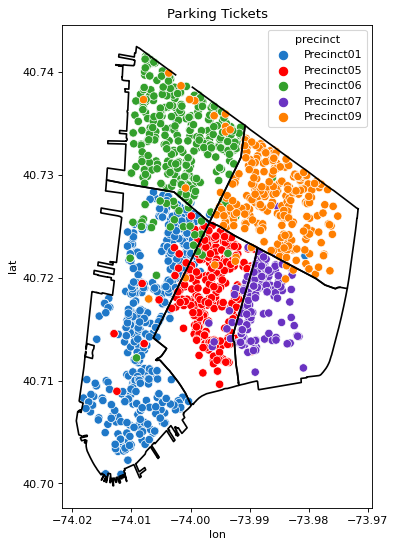

In [8]:
# Using our new palette we can plot the original parking ticket data and add the precinct boundaries using 
# plot_boundaries to make everything more readable.

plt.figure(figsize=(5,8))

sns.scatterplot(
    x='lon', y='lat', hue='precinct', palette=precinct_pal, data=manh_tickets
).set_title("Parking Tickets")
plot_boundaries(manh_bounds)

plt.show()

##  5.1 Multiclass Case

- Standard Support Vector Classifier models are able to handle multiclass outcome vectors by fitting all of the one-to-one SVC models for each pair of classes. This therefore involves fitting ${k \choose 2} = k(k-1)/2$
​
- SVC models which can be slow. The labels are predicted based on using all ${k \choose 2} = k(k-1)/2$ generate binary predictions which are then tabulated and the label with the most votes is choosen. See here for more details.

---

### 🚩 Exercise 11

Using the following function to try different values of kernel and C, what seems to produce the best model? 

Hint - recommended kernels to try include rbf, poly, and linear.

In [ ]:
# Following not needed, but makes life easier
gs_svc = sklearn.model_selection.GridSearchCV(
    make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.SVC()
    ),
    [
        {
            # Other kernels
            "svc__kernel": ["rbf"],
            "svc__C": np.logspace(-2, 2, num=10)
        },
        {
            # For polynomial part only
            "svc__kernel": ["poly"],
            "svc__degree": [1, 2, 3],
            "svc__C": np.logspace(-2, 2, num=10)
        }
    ],

    # Setting a random_state has no effect when shuffle is False. 
    # You should leave random_state to its default (None), or set shuffle=True.
    cv = sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)
).fit(X,y)


plot_margin(gs_svc, manh_tickets, x='lon', y='lat', cat='precinct', show_support_vectors = False, nx=10000, ny=10000)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


---

### 🚩 Exercise 12

Comment out the line of code that includes the `StandardScaler` in the pipeline below. 

- What happens to the models predictive performance? 

- Try adjusting C and or kernel to see if you can improve things

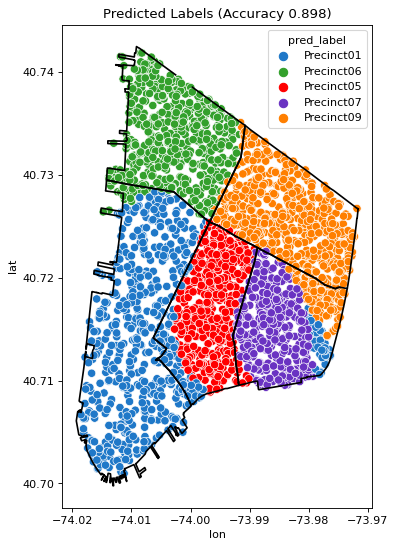

In [9]:
m_svc2 = make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.svm.SVC(C=50, kernel="rbf")
).fit(X,y)

model_test_assess(m_svc2, inc_report=False)

If we change the value C from 1 to 100 the hyperplane fits sligtly better, however the output is practically the same, so we will keep C = 50 in order to avoid high variance and low/high variance


**REMARK** 

An alternative to the one-vs-one behavior of SVC is to instead fit a one-vs-rest model, in sklearn this is only supported by the `LinearSVC()` classifier model. 

This modeling approach needs to only fit $k$ SVM models, and is therefore usually much faster for large $k$. 

However, due to implementation details of the underlying fitting library it does not support non-linear kernels. As with other SVM models it is important to scale our data before fitting.

---

### 🚩 Exercise 13

Using the following function try different values of C to tune the model, how does its performance compare to the SVC model?

Note that inside of the function  `model_test_assess` the testing data is used !



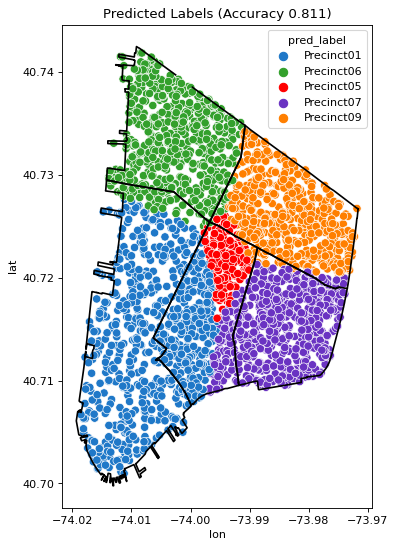

              precision    recall  f1-score   support

  Precinct01       0.64      0.92      0.75       500
  Precinct05       0.91      0.25      0.40       500
  Precinct06       0.90      1.00      0.95       500
  Precinct07       0.80      0.98      0.88       500
  Precinct09       0.96      0.91      0.94       500

    accuracy                           0.81      2500
   macro avg       0.84      0.81      0.78      2500
weighted avg       0.84      0.81      0.78      2500

None


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


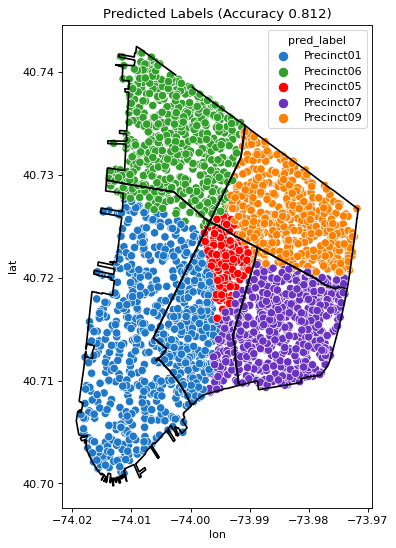

              precision    recall  f1-score   support

  Precinct01       0.64      0.92      0.75       500
  Precinct05       0.90      0.26      0.41       500
  Precinct06       0.90      1.00      0.95       500
  Precinct07       0.80      0.98      0.88       500
  Precinct09       0.96      0.91      0.94       500

    accuracy                           0.81      2500
   macro avg       0.84      0.81      0.78      2500
weighted avg       0.84      0.81      0.78      2500

None


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


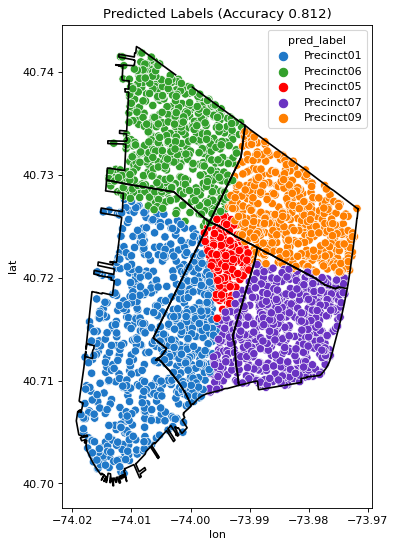

              precision    recall  f1-score   support

  Precinct01       0.64      0.92      0.75       500
  Precinct05       0.90      0.26      0.41       500
  Precinct06       0.90      1.00      0.95       500
  Precinct07       0.80      0.98      0.88       500
  Precinct09       0.96      0.91      0.94       500

    accuracy                           0.81      2500
   macro avg       0.84      0.81      0.78      2500
weighted avg       0.84      0.81      0.78      2500

None


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


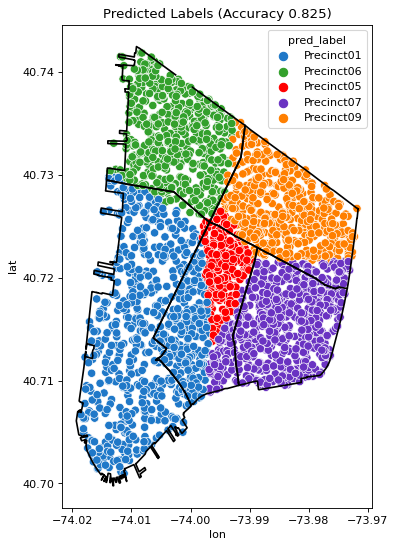

              precision    recall  f1-score   support

  Precinct01       0.67      0.97      0.79       500
  Precinct05       0.90      0.35      0.51       500
  Precinct06       0.97      0.96      0.96       500
  Precinct07       0.77      0.99      0.87       500
  Precinct09       0.95      0.85      0.90       500

    accuracy                           0.82      2500
   macro avg       0.85      0.82      0.81      2500
weighted avg       0.85      0.82      0.81      2500

None


In [10]:
def fit_lsvc(C):
    m_lsvc = make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.svm.LinearSVC(C=C, max_iter=5000)
    ).fit(X,y)
    
    model_test_assess(m_lsvc)

print(fit_lsvc(1))
print(fit_lsvc(50))
print(fit_lsvc(100))
print(fit_lsvc(500))

When we change the C value, we observe 

---

## 7. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can generate your PDF and turn it in on gradescope under the `mlp-week08` assignment.